In [2]:
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

import os

In [3]:
DATASET_PATH = "../datasets/google-drawings/"
x = np.load(DATASET_PATH+"full_numpy_bitmap_axe.npy")
x.shape, x.dtype

((1000, 784), dtype('uint8'))

130


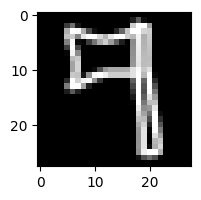

In [4]:
print(len(os.listdir(DATASET_PATH)))

# 138 files
# all containing 1000 images
# removed duplicate ... (n).npy files
# seemed to have repeated images

img = np.load(DATASET_PATH+"full_numpy_bitmap_axe.npy")[0]
img = img.reshape(28,28)

plt.figure(figsize=(2,2))
plt.imshow(img, cmap='gray')

In [220]:
files = os.listdir(DATASET_PATH)
files = sorted([name for name in files if ".npy" in name and "sketch" not in name])
n_classes = len(files) 
print(len(files), n_classes)

BS = 32

def load_batch(BS):
    
    batch = torch.zeros((BS, 1, 28, 28))
    labels = torch.zeros(BS).type(torch.uint8)
    #print(labels.shape)
    #print(batch.shape)

    # 130 file
    # 1000 samples per file
    file_indices = np.random.randint(0, n_classes, BS)
    batch_indices = np.random.randint(0, 1000, BS)
    
    for i, (fi, bi) in enumerate(zip(file_indices, batch_indices)):
        
        item = np.load(DATASET_PATH+files[fi])[bi]
        batch[i] = torch.from_numpy(item).type(torch.float).reshape(28,28)
        #labels[i] = F.one_hot(torch.tensor(fi), 128)
        labels[i] = torch.tensor(fi)
        
    return batch, labels

xs, ys = load_batch(2)
xs.shape, ys

128 128


(torch.Size([2, 1, 28, 28]), tensor([62, 55], dtype=torch.uint8))

In [235]:
class mlp(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 128),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)
    
device = torch.device("mps")    
model = mlp()
#model = model.to(device)

pred = model(xs)
print(pred.shape)

crit = nn.NLLLoss()

crit(pred, ys)

torch.Size([2, 128])


tensor(-8.0721e-08, grad_fn=<NllLossBackward0>)

In [240]:
model = model.to(device)
model.train()

lr = 0.01
mom = 0.0
BS = 256
N_EPOCHS = 5
N_BATCHES = int(128*1000/BS)

crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.0)

losses = []
accs = []

for epoch in tqdm(range(N_EPOCHS)):
    for n_batch in range(N_BATCHES):
        batch, labels = load_batch(BS)
        
        optim.zero_grad()

        out = model.forward(batch.to(device))
        loss = crit(out, labels.to(device))
        acc = ((out.argmax(dim=1).detach().cpu()==labels).sum().item()/float(BS))
        
        accs.append(acc)
        losses.append(loss.detach().cpu().item()/float(BS))

        
        if n_batch % 100 == 0: 
            print(loss.detach().cpu().item()/float(BS), acc)
        
        loss.backward()
        
        optim.step()
        

  0%|                                                        | 0/5 [00:00<?, ?it/s]

0.018974874168634415 0.00390625
0.018901363015174866 0.0234375
0.018830586224794388 0.046875
0.018881436437368393 0.03515625
0.018877588212490082 0.02734375


 20%|█████████▌                                      | 1/5 [00:15<01:00, 15.04s/it]

0.01875896379351616 0.06640625
0.018683694303035736 0.0859375
0.018717918545007706 0.07421875
0.018685445189476013 0.08203125
0.018738403916358948 0.0703125


 40%|███████████████████▏                            | 2/5 [00:30<00:45, 15.03s/it]

0.018671423196792603 0.0859375
0.01861649379134178 0.1015625
0.018752112984657288 0.0625
0.01868695206940174 0.08203125
0.018597887828946114 0.109375


 60%|████████████████████████████▊                   | 3/5 [00:45<00:30, 15.04s/it]

0.018689420074224472 0.078125


 60%|████████████████████████████▊                   | 3/5 [00:46<00:31, 15.54s/it]


KeyboardInterrupt: 

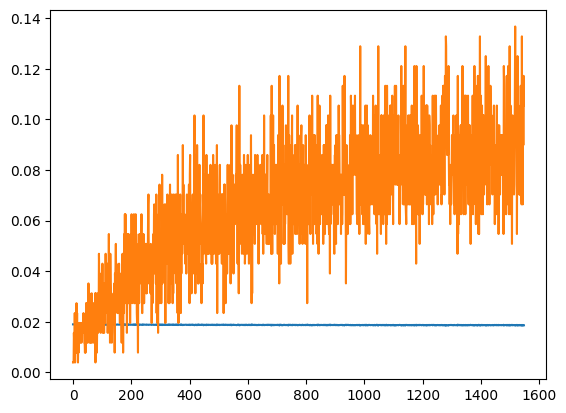

In [241]:
plt.plot(losses)
plt.plot(accs)